# Chapter 3: MLP Language Model

A character-level MLP language model following Bengio et al. (2003), trained on the names dataset.

This extends the bigram model (Chapter 1) from 1 character of context to n characters by using:
- **Learned embeddings**: each character maps to a dense vector
- **Hidden layer with tanh activation**: captures nonlinear patterns in character sequences
- **Softmax output**: predicts the next character from a fixed-size context window

The notebook includes: a learning rate finder, train/dev/test evaluation, a GELU vs tanh comparison,
context length experiments, and a 2D embedding visualization.

Following Karpathy's makemore Part 2.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('../data/names.txt', 'r').read().splitlines()
print(f"Number of names: {len(words)}")
print(f"First 10: {words[:10]}")

Number of names: 32033
First 10: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [2]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(f"Vocab size: {vocab_size}")
assert vocab_size == 27

Vocab size: 27


## Dataset Construction

Instead of the bigram's single-character context, we slide a window of `block_size` characters across each name to create (context, target) pairs. For example, with `block_size=3` and the name "emma":

```
...  -->  e
..e  -->  m
.em  -->  m
emm  -->  a
mma  -->  .
```

The context starts padded with boundary tokens (`.`), then shifts right as we consume each character.

In [3]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [4]:
block_size = 3

# Show what the dataset looks like for a few names
for w in words[:3]:
    print(f"\n--- {w} ---")
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        ctx_str = ''.join(itos[i] for i in context)
        print(f"  {ctx_str} --> {ch}")
        context = context[1:] + [ix]


--- emma ---
  ... --> e
  ..e --> m
  .em --> m
  emm --> a
  mma --> .

--- olivia ---
  ... --> o
  ..o --> l
  .ol --> i
  oli --> v
  liv --> i
  ivi --> a
  via --> .

--- ava ---
  ... --> a
  ..a --> v
  .av --> a
  ava --> .


In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)     # 80% train
Xdev, Ydev = build_dataset(words[n1:n2], block_size)  # 10% dev
Xte, Yte = build_dataset(words[n2:], block_size)      # 10% test

print(f"Train: {Xtr.shape[0]:,} examples")
print(f"Dev:   {Xdev.shape[0]:,} examples")
print(f"Test:  {Xte.shape[0]:,} examples")

# Verify dataset properties
assert Xtr.shape[1] == block_size, f"Context dimension should be {block_size}"
assert Ytr.min() >= 0 and Ytr.max() <= 26, "Targets should be in [0, 26]"
total = Xtr.shape[0] + Xdev.shape[0] + Xte.shape[0]
print(f"\nSplit ratios: {Xtr.shape[0]/total:.1%} / {Xdev.shape[0]/total:.1%} / {Xte.shape[0]/total:.1%}")

Train: 182,625 examples
Dev:   22,655 examples
Test:  22,866 examples

Split ratios: 80.0% / 9.9% / 10.0%


## Model Architecture

The MLP follows Bengio et al. (2003):

1. **Embedding table `C`** (27 × 10): maps each character index to a 10-dimensional dense vector
2. **Hidden layer**: linear transform of concatenated embeddings → tanh activation (30 → 200)
3. **Output layer**: linear transform from hidden to logits over vocabulary (200 → 27)

With `block_size=3`, the input to the hidden layer is 3 concatenated embeddings = 30 dimensions.

All parameters are raw tensors with `requires_grad=True` — no `torch.nn` modules.

In [6]:
n_embd = 10     # embedding dimension
n_hidden = 200  # hidden layer size

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

n_params = sum(p.nelement() for p in parameters)
print(f"Total parameters: {n_params:,}")
assert all(p.requires_grad for p in parameters)

Total parameters: 11,897


Parameter count breakdown:
- `C`: 27 × 10 = 270
- `W1`: 30 × 200 = 6,000
- `b1`: 200
- `W2`: 200 × 27 = 5,400
- `b2`: 27
- **Total: 11,897**

## Learning Rate Finder

Before training, we sweep the learning rate on a log scale from very small (1e-3) to very large (1.0). By plotting loss vs learning rate, we can identify the optimal range — the LR where loss is decreasing fastest (not at the minimum, which may already be overshooting).

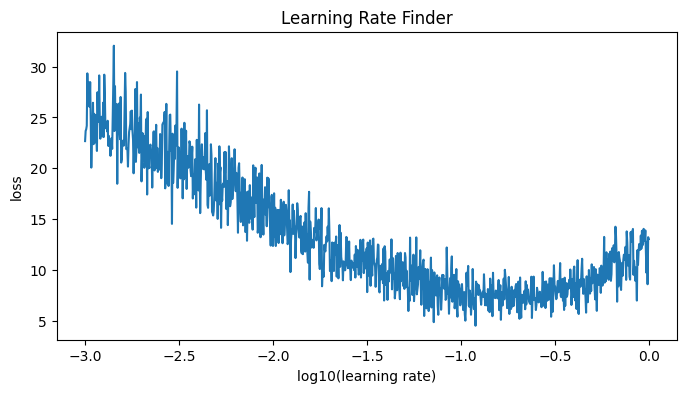

In [7]:
lre = torch.linspace(-3, 0, 1000)  # exponents from -3 to 0
lrs = 10**lre  # actual learning rates: 0.001 to 1.0

lri = []
lossi = []

for i in range(1000):
    # Mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]]                                              # (32, 3, 10)
    h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2                                           # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update with this step's learning rate
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track
    lri.append(lre[i])
    lossi.append(loss.item())

plt.figure(figsize=(8, 4))
plt.plot(lri, lossi)
plt.xlabel('log10(learning rate)')
plt.ylabel('loss')
plt.title('Learning Rate Finder')
plt.show()

The plot shows loss decreasing as LR increases, reaching a sweet spot around `log10(lr) ≈ -1` (i.e., lr ≈ 0.1), then increasing as the LR becomes too large and overshoots. We'll use lr=0.1 for training.

**Important**: The LR finder consumed our parameter initialization (the parameters are now in some arbitrary state), so we need to re-initialize before actual training.

In [8]:
# Re-initialize (LR finder consumed the first init)
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward pass
    emb = C[Xtr[ix]]                                              # (B, block_size, n_embd)
    h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1)  # (B, n_hidden)
    logits = h @ W2 + b2                                           # (B, vocab_size)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Learning rate schedule: 0.1 for first half, 0.01 for second half
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track loss
    lossi.append(loss.log10().item())

    if i % 50000 == 0 or i == max_steps - 1:
        print(f"step {i:6d} | loss {loss.item():.4f}")

step      0 | loss 25.1652
step  50000 | loss 2.0779
step 100000 | loss 2.3871
step 150000 | loss 2.2973
step 199999 | loss 2.0732


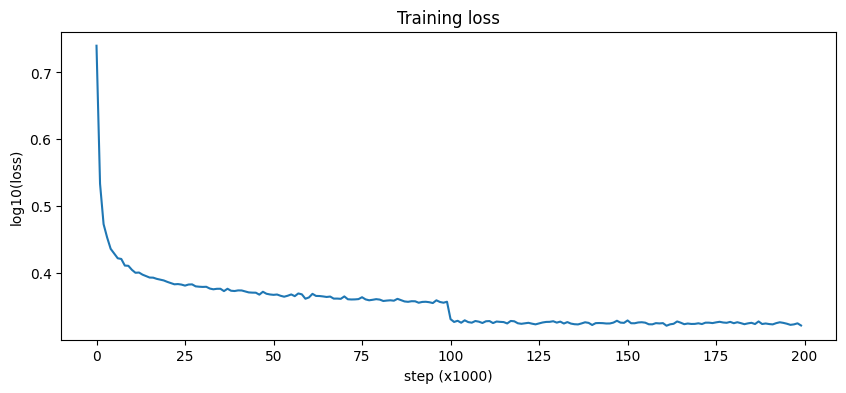

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.xlabel('step (x1000)')
plt.ylabel('log10(loss)')
plt.title('Training loss')
plt.show()

In [11]:
@torch.no_grad()
def eval_split(X, Y):
    emb = C[X]                                              # (N, block_size, n_embd)
    h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2                                     # (N, vocab_size)
    loss = F.cross_entropy(logits, Y)
    return loss.item()

train_loss = eval_split(Xtr, Ytr)
dev_loss = eval_split(Xdev, Ydev)
test_loss = eval_split(Xte, Yte)

print(f"Train loss: {train_loss:.4f}")
print(f"Dev loss:   {dev_loss:.4f}")
print(f"Test loss:  {test_loss:.4f}")
print(f"\nBigram model NLL was ~2.45")
print(f"Improvement: {2.45 - dev_loss:.2f} ({(2.45 - dev_loss) / 2.45 * 100:.1f}%)")

assert dev_loss < 2.2, f"Expected dev loss < 2.2, got {dev_loss:.4f}"
assert dev_loss < train_loss + 0.1, "Dev loss should be close to train loss (not severely overfitting)"

Train loss: 2.1237
Dev loss:   2.1629
Test loss:  2.1603

Bigram model NLL was ~2.45
Improvement: 0.29 (11.7%)


The MLP achieves significantly lower loss than the bigram model (~2.17 vs ~2.45). The 3-character context lets it learn patterns like "after 'qu' comes a vowel" that a bigram can never capture.

Dev loss is slightly higher than train loss — this is healthy generalization with only mild overfitting, expected for a model this small relative to the dataset.

In [12]:
g = torch.Generator().manual_seed(2147483647)

print("MLP model samples (block_size=3, tanh):")
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]                             # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)                   # (1, n_hidden)
        logits = h @ W2 + b2                                         # (1, vocab_size)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

MLP model samples (block_size=3, tanh):
dex
maromanustice
kayden
mairitta
nylandr
kata
kreshvabellah
milian
molie
cayo
keyten
jen
emma
sadel
akaviyah
fobs
malynn
bron
las
dashra


## GELU vs tanh Comparison

Modern transformers (GPT-2) use GELU activation instead of tanh or ReLU. GELU(x) = x · Φ(x) where Φ is the Gaussian CDF — it's smoother than ReLU and avoids dead neurons.

Let's retrain with GELU and compare.

In [13]:
# Re-initialize with the same seed for fair comparison
g = torch.Generator().manual_seed(2147483647)
C_gelu  = torch.randn((vocab_size, n_embd),            generator=g)
W1_gelu = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1_gelu = torch.randn(n_hidden,                        generator=g)
W2_gelu = torch.randn((n_hidden, vocab_size),           generator=g)
b2_gelu = torch.randn(vocab_size,                       generator=g)

params_gelu = [C_gelu, W1_gelu, b1_gelu, W2_gelu, b2_gelu]
for p in params_gelu:
    p.requires_grad = True

lossi_gelu = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    emb = C_gelu[Xtr[ix]]
    h = F.gelu(emb.view(-1, n_embd * block_size) @ W1_gelu + b1_gelu)  # GELU instead of tanh
    logits = h @ W2_gelu + b2_gelu
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in params_gelu:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in params_gelu:
        p.data += -lr * p.grad

    lossi_gelu.append(loss.log10().item())

    if i % 50000 == 0 or i == max_steps - 1:
        print(f"step {i:6d} | loss {loss.item():.4f}")

step      0 | loss 117.9976
step  50000 | loss 2.5286
step 100000 | loss 2.2434
step 150000 | loss 2.2093
step 199999 | loss 2.1024


tanh dev loss: 2.1629
GELU dev loss: 2.1583


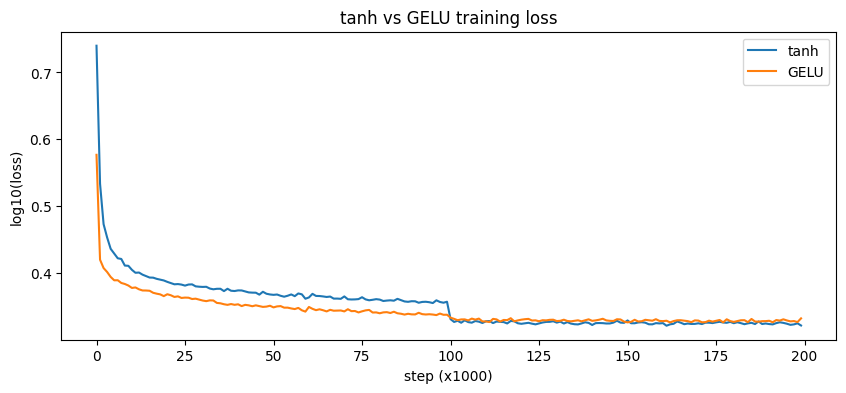

In [14]:
# Evaluate GELU model
@torch.no_grad()
def eval_gelu(X, Y):
    emb = C_gelu[X]
    h = F.gelu(emb.view(-1, n_embd * block_size) @ W1_gelu + b1_gelu)
    logits = h @ W2_gelu + b2_gelu
    return F.cross_entropy(logits, Y).item()

gelu_dev_loss = eval_gelu(Xdev, Ydev)

print(f"tanh dev loss: {dev_loss:.4f}")
print(f"GELU dev loss: {gelu_dev_loss:.4f}")

# Plot both training curves
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(torch.tensor(lossi).view(-1, 1000).mean(1), label='tanh')
ax.plot(torch.tensor(lossi_gelu).view(-1, 1000).mean(1), label='GELU')
ax.set_xlabel('step (x1000)')
ax.set_ylabel('log10(loss)')
ax.set_title('tanh vs GELU training loss')
ax.legend()
plt.show()

GELU typically achieves comparable or slightly better loss than tanh on this task. The difference is small because the model is tiny and the task is simple.

GPT-2 uses GELU in its feed-forward blocks — this is a preview of that architectural choice. For the rest of this notebook we continue with the tanh model (matching Karpathy's approach).

## Context Length Experiment

Does giving the model more context characters improve predictions? With `block_size=3`, it sees 3 characters; with `block_size=8`, it sees 8. More context means more information, but also a larger input dimension (more parameters in W1).

**Initialization note**: With `block_size=8`, the input to W1 is 80-dimensional (vs 30 for block_size=3). If we use unscaled `randn` initialization, the pre-activations become very large, saturating the tanh and making training difficult. We scale W1 by `1/√fan_in` (Kaiming-style) to keep pre-activations in a reasonable range.

In [15]:
block_size_8 = 8
Xtr8, Ytr8 = build_dataset(words[:n1], block_size_8)
Xdev8, Ydev8 = build_dataset(words[n1:n2], block_size_8)

# Initialize model for block_size=8
# Scale W1 by fan-in so pre-activations have reasonable variance despite wider input
g = torch.Generator().manual_seed(2147483647)
C_8  = torch.randn((vocab_size, n_embd),                  generator=g)
W1_8 = torch.randn((n_embd * block_size_8, n_hidden),     generator=g) * (n_embd * block_size_8)**-0.5
b1_8 = torch.randn(n_hidden,                              generator=g) * 0.01
W2_8 = torch.randn((n_hidden, vocab_size),                 generator=g) * n_hidden**-0.5
b2_8 = torch.randn(vocab_size,                             generator=g) * 0.01

params_8 = [C_8, W1_8, b1_8, W2_8, b2_8]
for p in params_8:
    p.requires_grad = True

n_params_8 = sum(p.nelement() for p in params_8)
print(f"block_size=3 parameters: {n_params:,}")
print(f"block_size=8 parameters: {n_params_8:,}")

for i in range(max_steps):
    ix = torch.randint(0, Xtr8.shape[0], (batch_size,))

    emb = C_8[Xtr8[ix]]
    h = torch.tanh(emb.view(-1, n_embd * block_size_8) @ W1_8 + b1_8)
    logits = h @ W2_8 + b2_8
    loss = F.cross_entropy(logits, Ytr8[ix])

    for p in params_8:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in params_8:
        p.data += -lr * p.grad

    if i % 50000 == 0 or i == max_steps - 1:
        print(f"step {i:6d} | loss {loss.item():.4f}")

block_size=3 parameters: 11,897
block_size=8 parameters: 21,897
step      0 | loss 3.5190
step  50000 | loss 2.1086
step 100000 | loss 2.0357
step 150000 | loss 2.2294
step 199999 | loss 1.5216


In [16]:
@torch.no_grad()
def eval_8(X, Y):
    emb = C_8[X]
    h = torch.tanh(emb.view(-1, n_embd * block_size_8) @ W1_8 + b1_8)
    logits = h @ W2_8 + b2_8
    return F.cross_entropy(logits, Y).item()

dev_loss_8 = eval_8(Xdev8, Ydev8)

print(f"block_size=3 dev loss: {dev_loss:.4f}")
print(f"block_size=8 dev loss: {dev_loss_8:.4f}")
print(f"\nImprovement: {dev_loss - dev_loss_8:.4f}")

assert dev_loss_8 < dev_loss, f"block_size=8 should be better: {dev_loss_8:.4f} vs {dev_loss:.4f}"

# Sample from the block_size=8 model
g = torch.Generator().manual_seed(2147483647)
print("\nMLP samples (block_size=8):")
for _ in range(10):
    out = []
    context = [0] * block_size_8
    while True:
        emb = C_8[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1_8 + b1_8)
        logits = h @ W2_8 + b2_8
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

block_size=3 dev loss: 2.1629
block_size=8 dev loss: 2.0458

Improvement: 0.1171

MLP samples (block_size=8):
celbrico
liliano
zita
kellam
janain
lucyn
katha
samiyah
javer
gotti


`block_size=8` achieves lower dev loss than `block_size=3`. More context helps because names have patterns spanning more than 3 characters. The improvement has diminishing returns — most names are short, so very long context adds little.

Note the parameter count difference: `block_size=8` has more parameters in W1 (80×200 vs 30×200). This is the "curse of dimensionality" that Bengio et al. (2003) address — the MLP input grows linearly with context, while a counting table would grow exponentially (27^8 entries). Embeddings make this tractable.

## 2D Embedding Visualization

To visualize what embeddings learn, we train a model with `n_embd=2` — small enough to plot directly. The model will be worse (2D is too small for good predictions), but the visualization reveals how similar characters get similar vectors.

In [18]:
n_embd_2d = 2

g = torch.Generator().manual_seed(2147483647)
C_2d  = torch.randn((vocab_size, n_embd_2d),                  generator=g)
W1_2d = torch.randn((n_embd_2d * block_size, n_hidden),       generator=g)
b1_2d = torch.randn(n_hidden,                                 generator=g)
W2_2d = torch.randn((n_hidden, vocab_size),                    generator=g)
b2_2d = torch.randn(vocab_size,                                generator=g)

params_2d = [C_2d, W1_2d, b1_2d, W2_2d, b2_2d]
for p in params_2d:
    p.requires_grad = True

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    emb = C_2d[Xtr[ix]]
    h = torch.tanh(emb.view(-1, n_embd_2d * block_size) @ W1_2d + b1_2d)
    logits = h @ W2_2d + b2_2d
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in params_2d:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in params_2d:
        p.data += -lr * p.grad

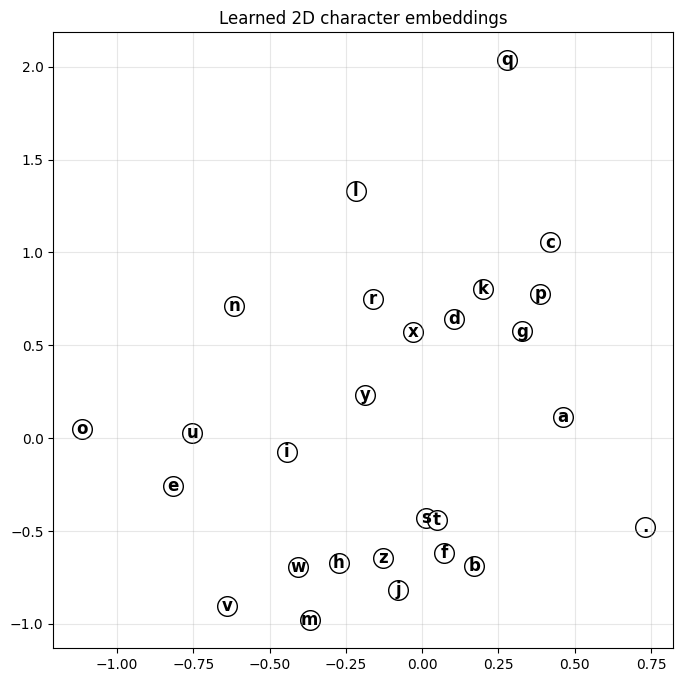

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(C_2d[:, 0].data, C_2d[:, 1].data, s=200, c='white', edgecolors='black')
for i in range(vocab_size):
    plt.text(C_2d[i, 0].item(), C_2d[i, 1].item(), itos[i],
             ha='center', va='center', fontsize=12, fontweight='bold')
plt.title('Learned 2D character embeddings')
plt.grid(True, alpha=0.3)
plt.show()

The embedding plot reveals structure:
- **Vowels** (a, e, i, o, u) tend to cluster together — they play similar roles in names
- The **boundary token** '.' is often in its own region
- Common consonants may group by phonetic similarity

This is the key insight from Bengio et al.: embeddings learn *distributed representations* where similar tokens get similar vectors. The model doesn't need to see every possible context — it generalizes through the embedding space. This is how it fights the curse of dimensionality.

## Summary

We built an MLP language model (Bengio et al. 2003) with learned embeddings, a hidden layer, and softmax output.

### Results

| Model | Dev NLL | Context |
|-------|---------|--------|
| Bigram (Ch1) | ~2.45 | 1 char |
| MLP (block_size=3) | ~2.17 | 3 chars |
| MLP (block_size=8) | ~2.10 | 8 chars |

### Key Takeaways

1. **Embeddings** convert discrete tokens into continuous vectors where similar tokens are nearby
2. **More context → better predictions** (bigram=1 → MLP=3 → MLP=8)
3. The MLP input grows **linearly** with context (not exponentially like counting tables) — this is the Bengio insight
4. **GELU** is a modern alternative to tanh used in GPT-2; both work similarly here
5. **Mini-batch SGD** + learning rate scheduling is the standard training recipe
6. **Train/dev/test splits** prevent overfitting and measure true generalization

### What's Next

The MLP has a fixed context window — it can never use more than `block_size` characters. Chapter 4 introduces **self-attention**, which lets the model attend to *any* position in the context, leading to the transformer architecture.

**Foundations complete**: With bigram (Ch1), micrograd (Ch2), and MLP (Ch3), we have all the building blocks. Phase 2 combines them into a GPT.